In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
import re

PValue=.01

Folders with Files in them

In [51]:
plugged_in_no_brower_7_20_22 = 'Plugged_In_No_Browser_7-20-22' # 10 runs each no enough for statistics
plugged_in_no_brower_7_21_22 = 'Plugged_In_No_Browser_7-21-22' # 50 runs each
plugged_in_with_brower_7_26_22 = 'Plugged_In_With_Browser_7-26-22' # 50 runs attemptings to see slow downs with new
                                                                   # functionality to show processor speeds

battery_two_test_at_once_7_27_22 = 'Battery_Two_Test_At_Once_7_27_22' # Ran two tests at once to test output 
                                                                      # of cpu speed outputs
plugged_in_no_brower_8_9_22 = 'Plugged_In_No_Browser_8_9_22' # 1,000 runs of each program on two patterns. Looking
                                                             # to test Trot's theory that VM's don't stabilize 
                                                             # runtime b/c to complicated.

currentPath = plugged_in_no_brower_8_9_22

Search transcript files and process their contents for patterns and programs runs, iterations start and end, and cpu speed throttling changes.

In [52]:
with open(currentPath+'/' + 'transcript.txt') as f:
    lines = f.readlines()

f.close()
start_of_sections = []
speed_changes = []
start_of_iterations = []
end_of_iterations = []

find_prog_patt = '(pexl|lpeg|rosie).* (\\w+) +\\d+'
find_prog_patt_searcher = re.compile(find_prog_patt)

speed_limit_pattern = ' (\\d+)\n'
speed_limit_searcher = re.compile(speed_limit_pattern)

for i in range(0,len(lines)):
    line = lines[i]
    
    if line.find('Benchmark') > -1:
        match = find_prog_patt_searcher.search(line)
        assert len(match.groups() ) == 2,('Matched to many things in the pattern identifier '+match.groups())
        line = match.groups()[1]+'_'+match.groups()[0]
        start_of_sections.append( (line,i) )
        print(line,' ',i)
    elif line.find('CPU_Speed_Limit') > -1:
        match = speed_limit_searcher.search(line)
        if match is None:
            print('ignoring line ', line,i) #I use this output to check that only a few lines are being ignored
            continue
        assert len(match.groups() ) == 1,'Matched to many things looking for speed limit changes'
        speed_num = match.groups()[0]
        speed_changes.append( (int(speed_num),i) )
    elif line.find('Running ') > -1:
        start_of_iterations.append( (line,i) )
    elif line.find('Done.') > -1:
        end_of_iterations.append( (line,i) )


abram_lpeg   18
abram_pexl   8064
abram_rosie   13095
longword_lpeg   19148
longword_pexl   27194
longword_rosie   32225


In [53]:
speed_changes

[(100, 17), (100, 19147)]

In [54]:
#malformed_start_point = start_of_sections[4][1] #The laptop ran out of battery and shut down during this test. This
                                                # resulted in data sections that were to poorly formated for 
                                                # recovery. 

In [55]:
# Removing the data that is to malformed for use. 
# This bit also stitches the start and end of each iteration together. together. Because of the malformed section the start and end lists don't have
#   equal lengths and so the inbuilt stich function can't be used.

In [56]:
# Function to remove bad data. You feed a list of tuples, the index where the bad data starts, and the location of 
#    each lines index value. It returns the same list except for entries whose index is greater than the index of 
#    the begining of the malformed section.

def remove_malformed(data,point,location_of_index):
    assert type(data) == list, 'data is not a list and so cannot remove malformed section'
    assert type(point) == int, 'start index of malformation is not int, must be an int'
    assert type(data[0][location_of_index]) == int, 'data found at index specified is not an int'
    
    temp = []
    for entry in data:
        if entry[location_of_index] > point:
            continue
        else:
            temp.append(entry)
    return temp

In [57]:
#Maybe I should put these lists in a dictionary so I can iterate over them. But this is fine for now.
#start_of_iterations = remove_malformed(start_of_iterations,malformed_start_point,1)
#end_of_iterations = remove_malformed(end_of_iterations,malformed_start_point,1)
#speed_changes = remove_malformed(speed_changes,malformed_start_point,1)
interations = list(zip(start_of_iterations,end_of_iterations))


In [58]:
# Idea - First loop looks to consume any speed changes that happen in between iterations then loops to add intra
#         speed changes to a list. One important assumption is that starting speed is 100. Could implement a check
#          to ensure that's true but not sure it ever isn't.

BIG_MAGIC_NUMBER = 10000000000000
current_speed_idx = 0
current_speed = 100
runs_w_speed = []

counter = 0

for entry in interations:
    temp_speeds = []
    name = None
    
    start_current_entry_loc = entry[0][1] # 1st element in tuple is start index of iteration
    end_current_entry_loc = entry[1][1]   # 2nd entry in tuple is end index of iteration
    

    if speed_changes:
        if current_speed_idx >= len(speed_changes):
            current_speed_loc = BIG_MAGIC_NUMBER
        else:
            current_speed_loc = speed_changes[current_speed_idx][1] # 2nd index of tuple is current cpu_speed_limit
    else:
        current_speed_loc = BIG_MAGIC_NUMBER # very large magic number
        
    # Inter Loop - consume and update speed to be the last change before the start of current iteration
    while start_current_entry_loc > current_speed_loc:
        current_speed_idx += 1
        
        if current_speed_idx >= len(speed_changes):
            current_speed_loc = BIG_MAGIC_NUMBER
            current_speed = speed_changes[ (len(speed_changes) -1)][0]
        else:
            current_speed_loc = speed_changes[current_speed_idx][1]
            current_speed = speed_changes[current_speed_idx-1][0]
    
    # Intra Loop - append most recent speed to list, update speed and repeat until we find a speed change
    #               after end of current iteration
    while end_current_entry_loc > current_speed_loc:
        temp_speeds.append( current_speed )
        current_speed_idx += 1
        
        # If final speed change is before last iteraction this check prevents an index out of bounds error
        if current_speed_idx < len(speed_changes):
            current_speed_loc = speed_changes[current_speed_idx][1]
            current_speed = speed_changes[current_speed_idx-1][0]
        else:
            current_speed_loc = BIG_MAGIC_NUMBER
            current_speed_idx = len(speed_changes) - 1
            current_speed = speed_changes[current_speed_idx][0]
        
    # This ensures that the speed list isn't empty and that if there are no changes it has the most recent speed
    temp_speeds.append(current_speed)
   
    # Loop that adds the appropriate section name to each iteration
    for i in range(0,(len(start_of_sections)+1)):
        if name is None:
            if i == len(start_of_sections):
                name = start_of_sections[i-1][0]
            elif start_current_entry_loc < start_of_sections[i][1]:
                name = start_of_sections[i-1][0]

        else:
            continue
    
    runs_w_speed.append( (name,entry,temp_speeds.copy()) )

In [59]:
runs_w_speed[0][2]

[100]

Importing Raw Data

In [60]:
# This sections removes duplicate consecutive outputs from a bug in the data generating program.
#  Each hyperfine loop instantiated a version of the speed monitor but didn't ever close it. Then when the 2nd loop
#  started, Longword pattern, each speed monitor instance was reporting the data. Thus double reports of the 
#  same data. This goes through and pops all those double reports.

for run in runs_w_speed:
    if len(run[2]) > 1:
        counter = len(run[2])-1
        i = 0
        while i < counter:
            if run[2][i] == run[2][i+1]:
                run[2].pop(i+1)
                counter += -1
                i += -1
            i += 1
min_speed = min(runs_w_speed[0][2])

for run in runs_w_speed:
    if min(run[2]) < min_speed:
        print(min_speed,run[0:2])
        min_speed = min(run[2])
runs_w_speed[0]

('abram_lpeg',
 (("Running 50 iterations of test 'abram'\n", 22), ('Done.\n', 25)),
 [100])

In [63]:

# This creates a dictionary containing each of the pattern/program combos found in the transcript file. Keys are
#  the pattern_program name and values are a list lists of the "cpu speed" for each iteration whose "name" 
#  matchs the key.
Speed_Dic ={}
patterns_identified = []
for item in start_of_sections:
    patterns_identified.append(item[0])
    Speed_Dic[item[0]] = []

for pattern in patterns_identified:
    counter = 0
    for run in runs_w_speed:
        name = run[0]
        if name.find(pattern) != -1:
            counter += 1
            #print('Pattern ',pattern,' Name ',run,' Counter ',counter)
            Speed_Dic[pattern].append(run[2])


In [64]:
Speed_Dic['abram_rosie'][0]

[100]

In [67]:
# This creates a dictionary whose keys are the pattern_program combo found in the transcript. The values are a 
#  two dimensional dataframe. 1 column is the duration of each iteration. 2nd column is a list of the "cpu speed/s"
#  during that iteration.

DF_Dic ={}

folder_path = currentPath +'/'
whats_inside = os.listdir(currentPath)
colors = ['green','blue','red']

for file in whats_inside:
    if file.find('~') > -1:
        continue
    elif file.find('.DS_Store') > -1:
        continue
    elif file.find('#') > -1:
        continue
    elif file.find('.txt') > -1:
        continue
    
    print('File name - ',file)
    name_pattern = file.split('-')[0]
    assert file.find('.json') != -1, ('Trying to read a non .json file '+file)
    temp = pd.read_json(folder_path+file, orient = 'records')
    
    progNames = []
    for j in range(0,temp.shape[0]):
        command = temp.iloc[j,0]['command']
        
        if command.find('lpeg') != -1:
            found_prog = 'lpeg'
        elif command.find('pexl') != -1:
            found_prog = 'pexl'
        elif command.find('rosie') != -1:
            found_prog = 'rosie'
        
        print('Pattern name - ',name_pattern,found_prog)
        tempDF = pd.DataFrame(columns = [found_prog,found_prog+'_Speed'])
        tempDF[found_prog] = temp.iloc[j,0]['times']
        warmup_runs = len(Speed_Dic[name_pattern+'_'+found_prog]) - tempDF[ found_prog ].size
        # There are 5 warm-up iterations before each run is recorded. These warmups are in the transcript but not 
        #  the actual data.
        print('Found ',warmup_runs,' warm up runs.')
        #print('Length of json ',tempDF[found_prog].shape[0],' Length of .txt ',len(Speed_Dic[name_pattern+'_'+found_prog]))
        tempDF[found_prog+'_Speed'] = Speed_Dic[name_pattern+'_'+found_prog][warmup_runs:]
        
        DF_Dic[name_pattern+'_'+found_prog] = tempDF.copy()

File name -  abram-captureAll-22941.json
Pattern name -  abram lpeg
Found  5  warm up runs.
Pattern name -  abram pexl
Found  5  warm up runs.
Pattern name -  abram rosie
Found  5  warm up runs.
File name -  longword-captureAll-8551.json
Pattern name -  longword lpeg
Found  5  warm up runs.
Pattern name -  longword pexl
Found  5  warm up runs.
Pattern name -  longword rosie
Found  5  warm up runs.


Function to calculate bandwidth value from data assuming bimodal distrobution

In [69]:
# Magic number comes from the wiki article on kde and how to estimate bandwidth from the data.
# The wiki article suggested .9 as a good approximation for bimodal/multimodal distrubutions.
def band_est(dataSet):
    magic_num = .9
    n = len(dataSet)
    samp_std = dataSet.std()
    q1 = np.quantile(dataSet,.25)
    q3 = np.quantile(dataSet,.75)
    IQR = q3-q1
    bandwidth_estimate = magic_num * min(samp_std,IQR/1.34)*n**(-1/5)
    return bandwidth_estimate

Funtion to calculate and plot the kde graphs 

In [70]:
def kde_graph(data,title,ln_flag):
    
    dataArray = np.asarray(data[:,0], dtype=float)
    if ln_flag:
        dataArray = np.log(dataArray)
    
    dataArray = dataArray.reshape(-1,1)
    
    
    #dataArray = np.log(dataArray[0])
    
    fineness_of_graph = 10000
    
    band_estimate = band_est(dataArray)

    kde = KernelDensity(kernel='gaussian', bandwidth= band_estimate ).fit(dataArray)
    s = np.linspace(min(dataArray)[0],max(dataArray)[0],fineness_of_graph)
    e = kde.score_samples(s.reshape(-1,1))
    
    if title.find('lpeg') != -1:
        color = 'green'
    elif title.find('rosie') != -1:
        color = 'red'
    elif title.find('pexl') != -1:
        color = 'blue'
    else:
        color = 'black'
    
    plt.plot(s, e, c = color)
    plt.axhline(y=0)
    
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    #print("Minima: X:", s[mi],'\n        Y:', e[mi], '\n')
    #print("\nMaxima: X:", s[ma],'\n        Y:', e[ma],'\n')
    
    #if min(e[mi]) < -100:
    #    plt.yscale('symlog')
    
    mean = np.mean(dataArray)
    median = np.median(dataArray)
    
    for points in data:
        temp = np.mean(points[1])
        if ln_flag:
            point = np.log(points[0])
        else:
            point = points[0]
        if temp < 100:
            
            norm = point-min(dataArray)[0]

            
            stepSize = (max(dataArray)[0] - min(dataArray)[0])/fineness_of_graph
            
            dif = round( norm/stepSize) -1
            
            plt.scatter(point,e[dif], c ='purple',)
            
    plt.vlines(x=mean,ymin = min(e), ymax = max(e), colors = 'grey')
    plt.vlines(x=median,ymin = min(e), ymax = max(e), colors = 'teal')
    
    plt.title((title+' '+str(round(dataArray.std(),3) ) ) )
    plt.show();
    return (s[mi],e[mi]),(s[ma],e[ma])

In [71]:
def scale_speed(data):
    temp = data.copy()
    assert data.shape[1] == 2, 'Data has more/less columns than 2'
    assert type(data.iloc[0,1]) == list, 'Second column is not a list'
    
    for row in temp.index:
        if np.mean(temp.iloc[row,1]) < 100:
            #print(temp.iloc[row,0])
            #print(temp.iloc[row,0] * np.mean(temp.iloc[row,1])/100)
            temp.iloc[row,0] = temp.iloc[row,0] * np.mean(temp.iloc[row,1])/100
    return temp

dict_keys(['abram_lpeg', 'abram_pexl', 'abram_rosie', 'longword_lpeg', 'longword_pexl', 'longword_rosie'])


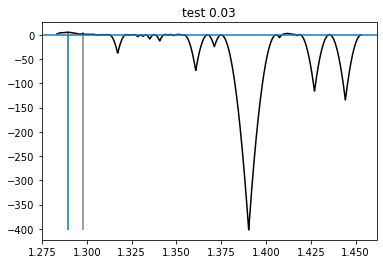

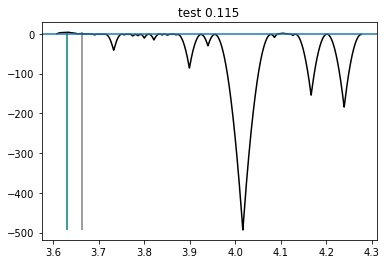

In [72]:
#print(type(DF_Dic['longword_lpeg'].iloc[0,1]))
test = scale_speed(DF_Dic['abram_lpeg'])
print(DF_Dic.keys())
kde_graph(test.to_numpy(),'test',True);
kde_graph(test.to_numpy(),'test',False);
#type(test.to_numpy()[0,0])

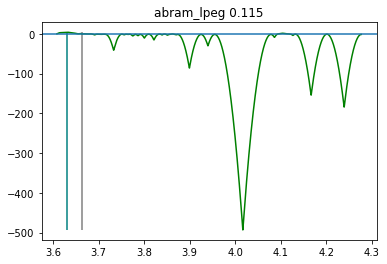

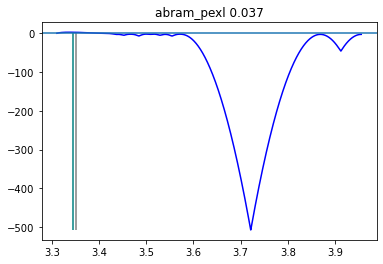

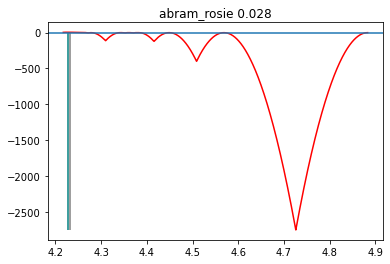

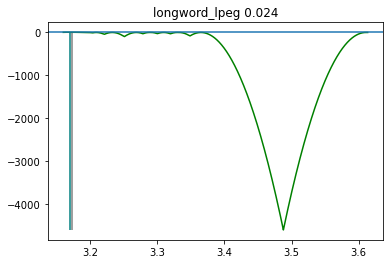

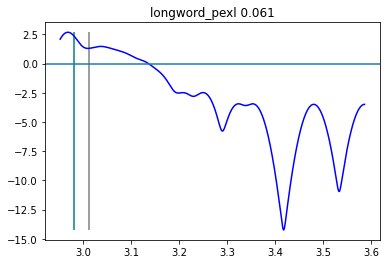

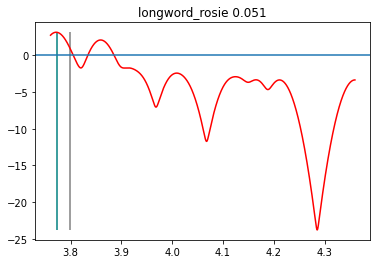

In [83]:
min_max_Dic = {}
for name in DF_Dic.keys():
    #min_max_Dic[name] = (kde_graph(DF_Dic[name].to_numpy(),name,True))
    min_max_Dic[name] = (kde_graph(DF_Dic[name].to_numpy(),name,False))
#mi , ma = kde_graph(testing,title,'test')


In [84]:
split_graph_dic = {}

for graph in min_max_Dic:
    mi, ma = min_max_Dic[graph]
    loc_val = zip(mi[0],mi[1])
    temp = []
    prog, name = graph.split('_')
    
    currentDF = DF_Dic[graph][name]
    
    temp.append(currentDF.min())
    
    for val in loc_val:
        if val[1] < 0:
            temp.append(val[0])
    
    temp.append(DF_Dic[graph][name].max())
    
    split_graph_dic[graph] = []
        
    for counter in range(1,len(temp)):
        if counter == len(temp)-1:
            split_graph_dic[graph].append(currentDF[[ test for test in currentDF >= temp[counter-1] ]])
        else:
            temp2 = currentDF[[test for test in currentDF >= temp[counter - 1] ] ]
            split_graph_dic[graph].append(temp2[[test for test in temp2 < temp[counter] ] ])
            
    sum_counter = 0
    for lists in split_graph_dic[graph]:
        sum_counter += len(lists)
    
    assert sum_counter == len(currentDF),('Missing/Double Counted Data in splitting set '+graph)

Attempting to combine all the data into one set to look at distrobution of clock times.

In [101]:
bar_graph_Dic = {}
for graph in split_graph_dic:
    print(graph)
    bar_graph_Dic[graph] = []
    for lists in split_graph_dic[graph]:
        length = len(lists)
        #print(length)
        bar_graph_Dic[graph].append(length)
bar_graph_Dic.keys()

abram_lpeg
abram_pexl
abram_rosie
longword_lpeg
longword_pexl
longword_rosie


dict_keys(['abram_lpeg', 'abram_pexl', 'abram_rosie', 'longword_lpeg', 'longword_pexl', 'longword_rosie'])

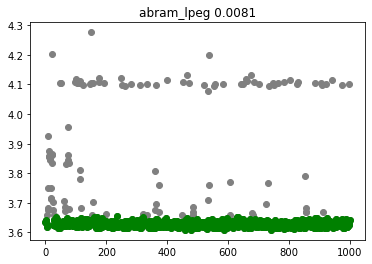

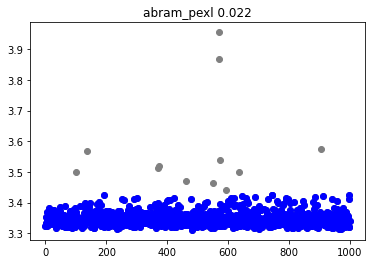

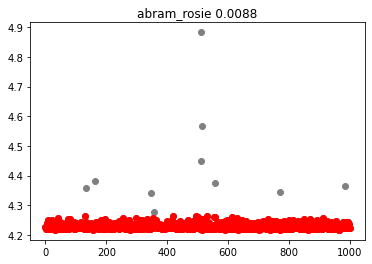

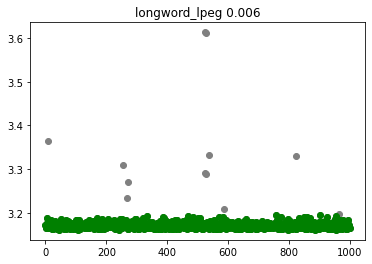

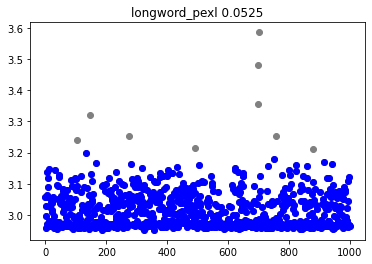

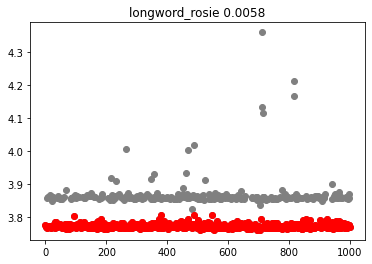

In [100]:


def JamieSuggestion(pattern):
    
    tempDF = DF_Dic[pattern]
    name = tempDF.columns[0]

    if name.find('lpeg') != -1:
        color = 'green'
    elif name.find('pexl') != -1:
        color = 'blue'
    elif name.find('rosie') != -1:
        color = 'red'

    plt.scatter(DF_Dic[DF][name].index, DF_Dic[DF][name], color = 'grey')

    #if name.find('lpeg') != -1:
    #    color = 'cyan'
    #elif name.find('pexl') != -1:
    #    color = 'darkorange'
    #elif name.find('rosie') != -1:
    #    color = 'indigo'

    plt.scatter(split_graph_dic[DF][0].index, split_graph_dic[DF][0], color = color)
    stand_dev = np.std(split_graph_dic[DF][0])
    plt.title(pattern+' '+str(round(stand_dev,4)))
    plt.show()
    
for DF in DF_Dic:
    JamieSuggestion(DF)

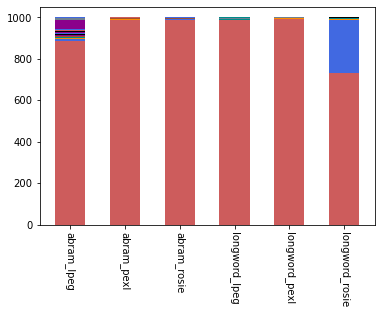

In [87]:
#labels = bar_graph_Dic.keys()
width = .55
colorList = ['indianred','royalblue','darkorange','darkcyan','sienna','darkmagenta','slategray','black']

fig, ax = plt.subplots()


for label in bar_graph_Dic.keys():
    count = 0
    sums = 0
    for num in bar_graph_Dic[label]:
        if count == 0:
            ax.bar(label,num,width,label=label, color = colorList[count])
            sums = num
        else:
            ax.bar(label,num,width, bottom = sums, label=count ,color = colorList[count%len(colorList)])
            sums += num
        count += 1
#ax.legend()
plt.xticks(rotation=270)
plt.show();